In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import wasserstein_distance
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [2]:
from plot import plot_bar_horizontal,plot_bar_vertical,vertical_boxplot,horizontal_boxplot,create_MAD_comparison_boxplot,create_MAD_comparison_violinplot
from read_data import apply_index_file

In [3]:
np.random.seed(42)
DATASET = "../../raw_data/massive.parquet"

# Dataset properties

## Global information

In [6]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [7]:
len(df)

45856811

In [8]:
df.head()

,filename,task_id,dataset,scan_nr,sequence,charge,mz,RT,iRT
0,131023_Sunil_PPT_Brain_A_02.mzML,216baaa4a7e842e2ae54d0fbef26d1cc,MSV000080692,5797,MQIFVK,2,383.21970,24.338255,52.767529
1,131023_Sunil_PPT_Brain_A_02.mzML,216baaa4a7e842e2ae54d0fbef26d1cc,MSV000080692,10965,FLGFFK,2,380.21524,39.359713,107.360574
2,131023_Sunil_PPT_Brain_A_02.mzML,216baaa4a7e842e2ae54d0fbef26d1cc,MSV000080692,9855,REVILNKST,2,552.31410,36.440266,96.750319
3,131023_Sunil_PPT_Brain_A_02.mzML,216baaa4a7e842e2ae54d0fbef26d1cc,MSV000080692,15548,LQGIVSWGSGCAQK,2,745.87384,51.097828,150.020844
4,131023_Sunil_PPT_Brain_A_02.mzML,216baaa4a7e842e2ae54d0fbef26d1cc,MSV000080692,12335,FPFFLR,2,413.73434,42.881750,120.160845


In [9]:
df[['filename','dataset','sequence','task_id']].nunique()

filename      2892
dataset         62
sequence    964395
task_id        165
dtype: int64

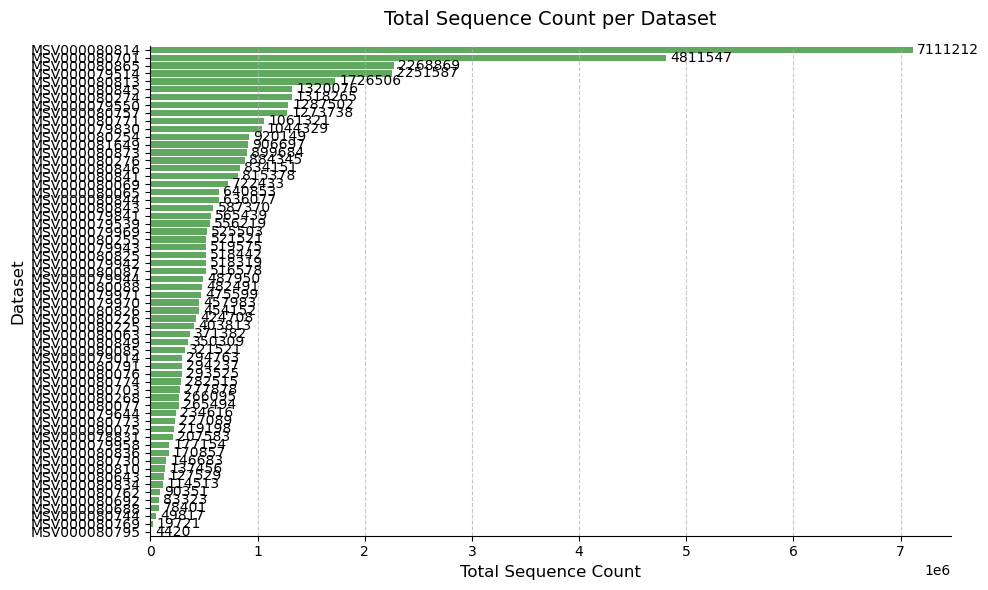

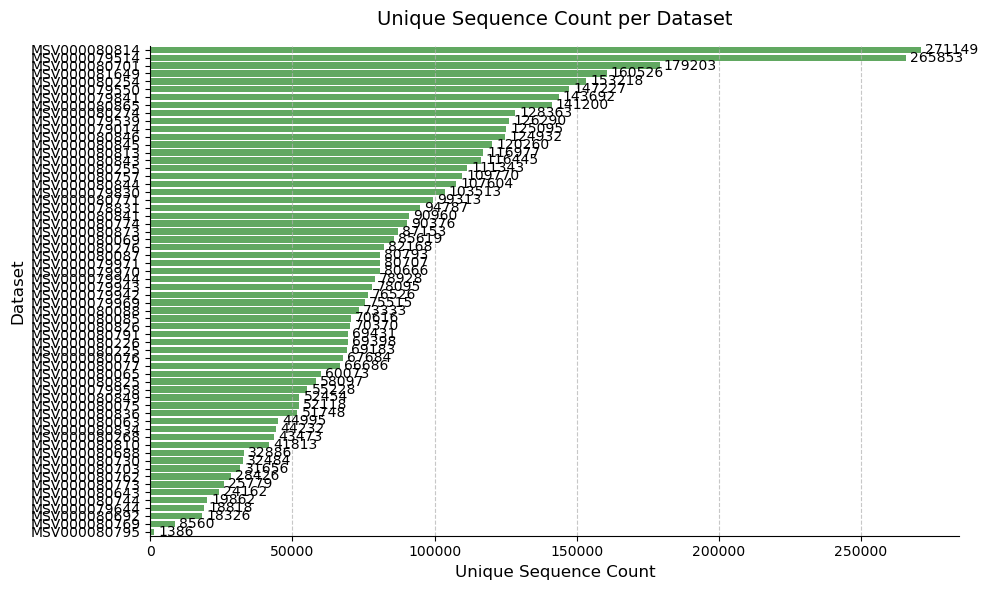

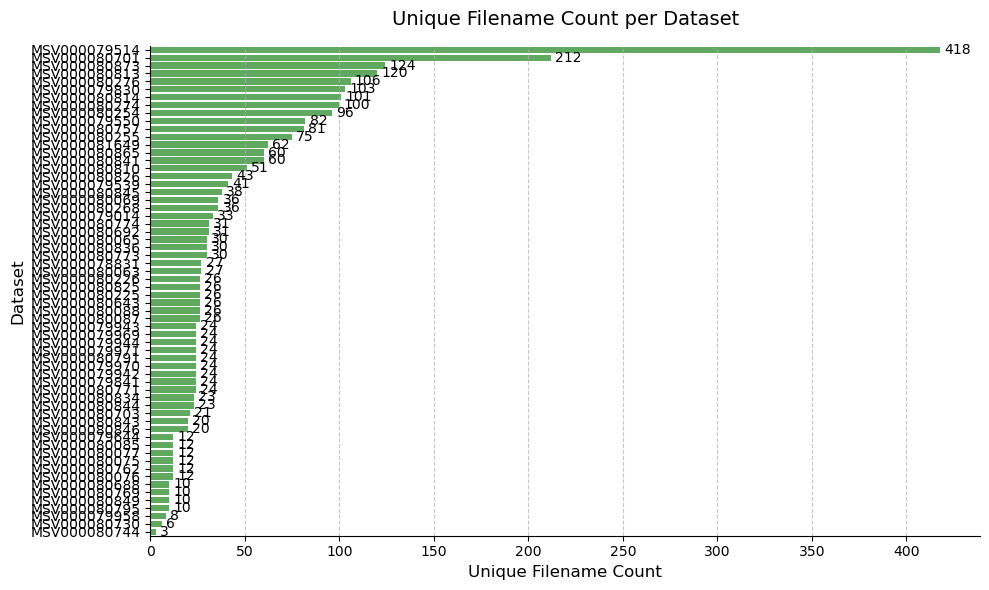

In [10]:
sequences_dataset = df.groupby('dataset')['sequence'].count()
plot_bar_horizontal(
    sequences_dataset,
    xlabel="Total Sequence Count",
    ylabel="Dataset",
    title="Total Sequence Count per Dataset"
)
# 2. Unique sequence counts
unique_sequences_dataset = df.groupby('dataset')['sequence'].nunique()
plot_bar_horizontal(
    unique_sequences_dataset,
    xlabel="Unique Sequence Count",
    ylabel="Dataset",
    title="Unique Sequence Count per Dataset"
)
unique_filenames_dataset = df.groupby('dataset')['filename'].nunique()
plot_bar_horizontal(
    unique_filenames_dataset,
    xlabel="Unique Filename Count",
    ylabel="Dataset",
    title="Unique Filename Count per Dataset"
)

## Peptide distribution

In [12]:
df = pd.read_parquet(DATASET,engine="pyarrow")

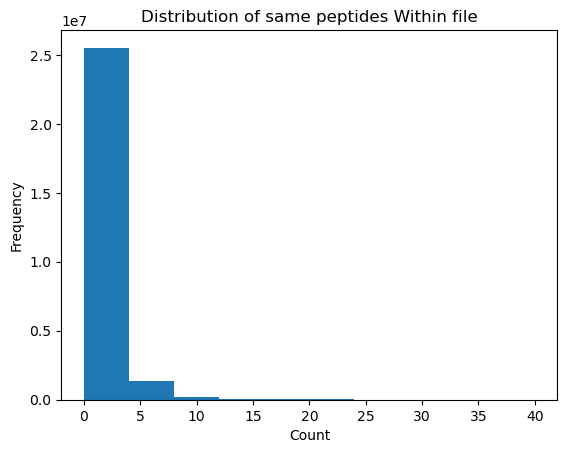

In [13]:
overlap_in_file = df.groupby(['sequence','filename'])['filename'].count()
overlap_in_file.plot.hist(range=(0, 40))
plt.title("Distribution of same peptides Within file")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

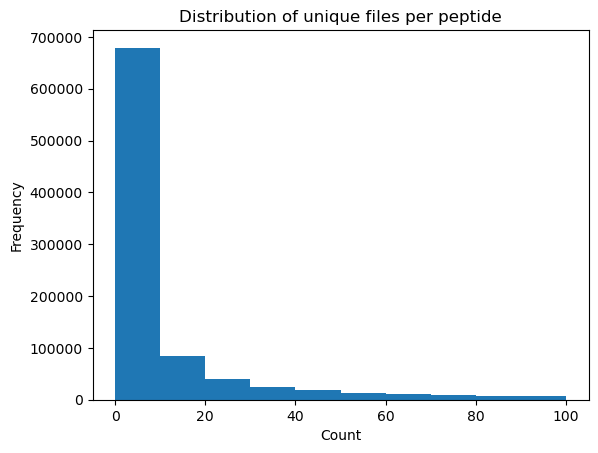

In [14]:
overlap_across_file = df.groupby('sequence')['filename'].nunique()
overlap_across_file.plot.hist(range=(0, 100))
plt.title("Distribution of unique files per peptide")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

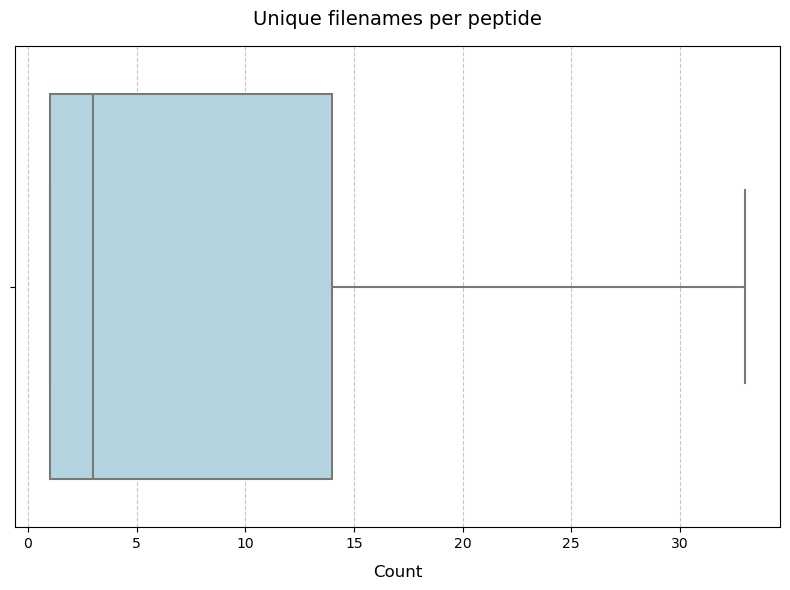

In [15]:
horizontal_boxplot(overlap_across_file,"Count","Unique filenames per peptide")

# Retention time analysis

In [17]:
df = pd.read_parquet(DATASET,engine="pyarrow")

## MAD

In [19]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    
    # Convert to numpy array if it's not already
    if isinstance(series, pd.Series):
        data = series.values
    else:
        data = np.asarray(series)
    
    # Calculate the median
    median_value = np.median(data)
    
    # Calculate the absolute deviations from the median
    abs_deviations = np.abs(data - median_value)
    
    # Calculate the median of the absolute deviations
    mad = np.median(abs_deviations)
    
    return mad

In [20]:
median_same_msrun = df.groupby(['sequence', 'filename'])['iRT'].apply(lambda x: median_absolute_deviation(x, 2)).dropna()
median_across_dataset = df.groupby(['sequence', 'dataset'])['iRT'].apply(lambda x: median_absolute_deviation(x, 2)).dropna()
median_across_all = df.groupby(['sequence'])['iRT'].apply(lambda x: median_absolute_deviation(x, 2)).dropna()

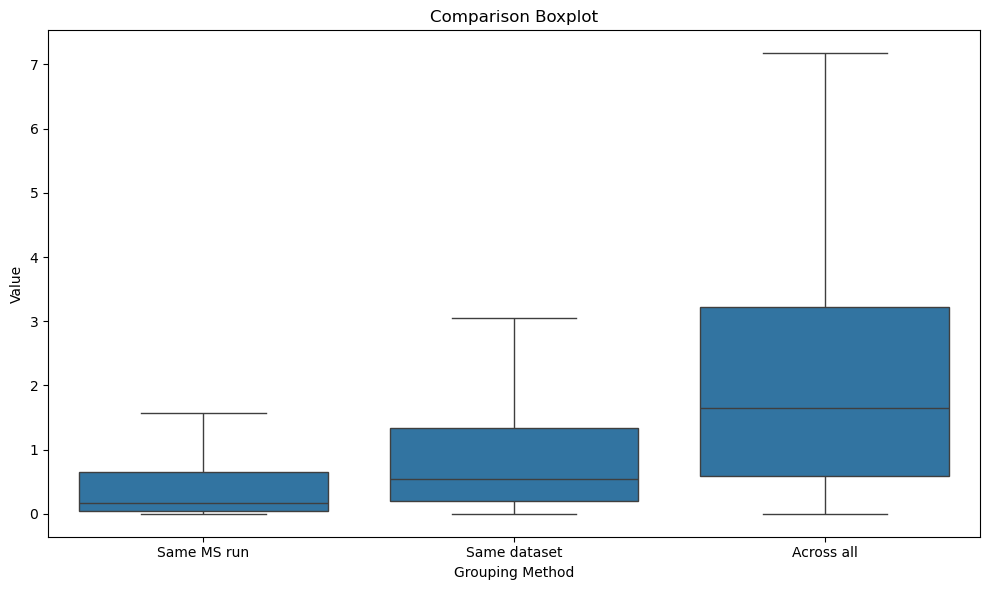

In [21]:
create_MAD_comparison_boxplot([median_same_msrun,median_across_dataset,median_across_all],["Same MS run","Same dataset","Across all"])

C:\Users\lambe\Documents\School\thesis\MTL-peptide-property-prediction_temp\src\plot.py:187: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='MAD', y='Group', data=df_violin, cut=0, ax=ax,


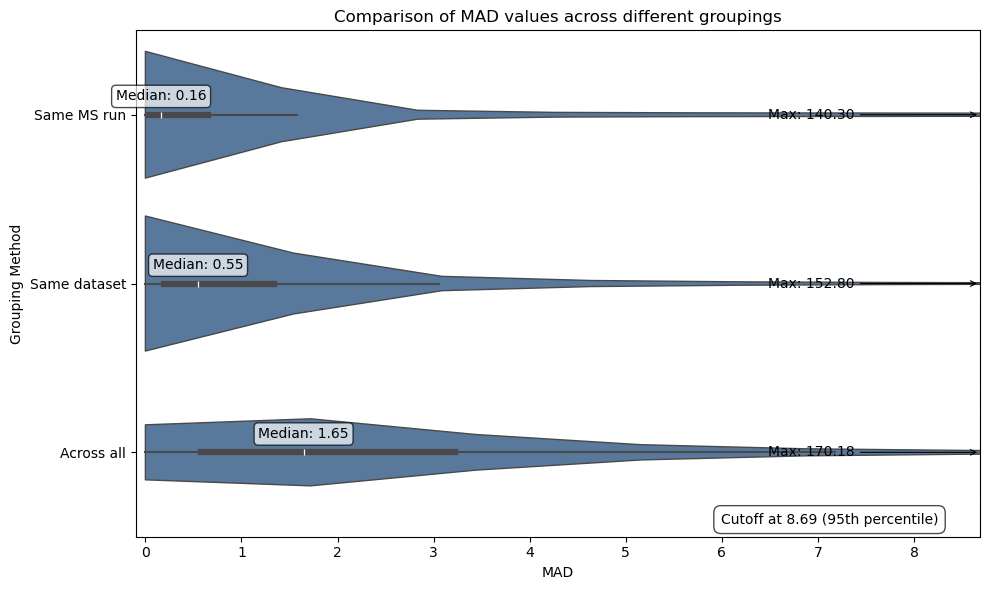

In [22]:
create_MAD_comparison_violinplot([median_same_msrun,median_across_dataset,median_across_all],["Same MS run","Same dataset","Across all"])

C:\Users\lambe\Documents\School\thesis\MTL-peptide-property-prediction_temp\src\plot.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


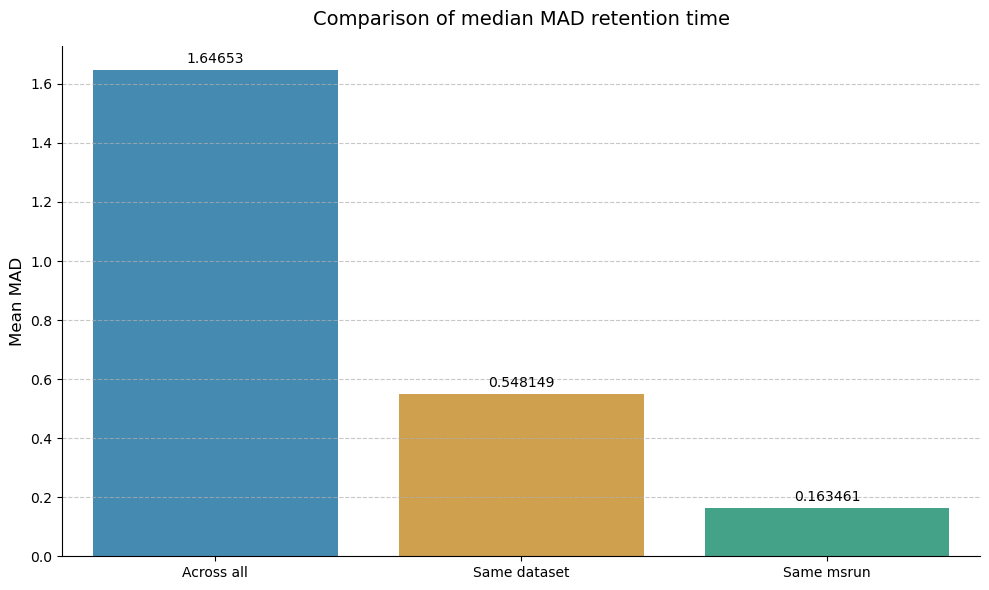

In [23]:
comparison = pd.Series(
    [median_same_msrun.median(),median_across_dataset.median(),median_across_all.median()],
    index=["Same msrun","Same dataset","Across all"]
)
# Call the plotting function with the Series
plot_bar_vertical(
    data_series=comparison,
    title="Comparison of median MAD retention time",
    xlabel="",
    ylabel="Mean MAD",
    figsize=(10, 6)
)

## KDE plots

In [25]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [26]:
def plot_kde_grouped(df, threshold, legend=None):
    grouped = df.groupby('sequence')
    for sequence, seq_group in grouped:
        plt.figure(figsize=(8, 6))
        # Group again within each sequence by filename to get iRT values
        for filename, values in seq_group.groupby('filename')['iRT']:
            values = list(values)  # Convert Series to list
            if len(values) >= threshold:
                label = f"{filename} (n={len(values)})"
                sns.kdeplot(values, label=label, fill=False)

        plt.xlabel("Retention Time")
        plt.ylabel("Density")
        if legend:
            plt.legend(title="Filename", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"KDE Plot for Sequence: {sequence}")
        plt.show()

In [27]:
overlap_across_msrun = df.groupby('sequence')['filename'].nunique()
overlap_in_msrun = df.groupby(['sequence','filename'])['filename'].count()

In [28]:
interesting_peptides_across = overlap_across_msrun[(overlap_across_msrun > 10) & (overlap_across_msrun < 30)].index
# Filter rows where the value is > 5
filtered = overlap_in_msrun[overlap_in_msrun > 5]

# Group by sequence and find sequences appearing more than 5 times
sequence_counts = filtered.groupby('sequence').count()
interesting_peptides_inside = sequence_counts[sequence_counts > 5].index
interesting_peptides = interesting_peptides_across.intersection(interesting_peptides_inside)[:10]

In [29]:
df_sequence = df[df['sequence'].isin(interesting_peptides)]

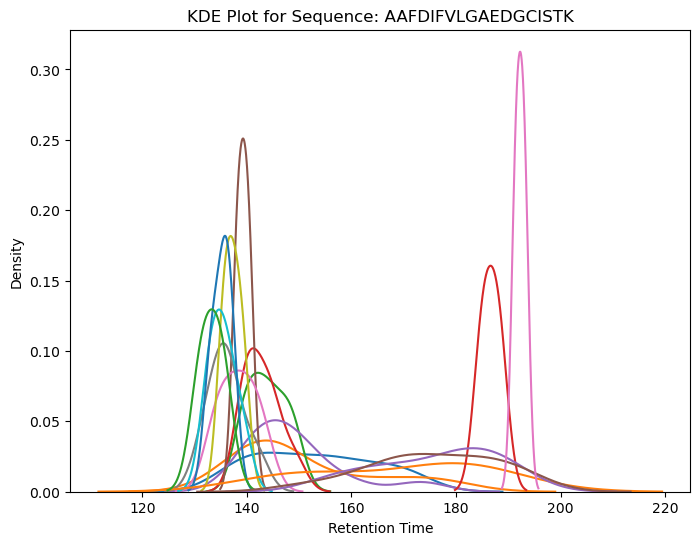

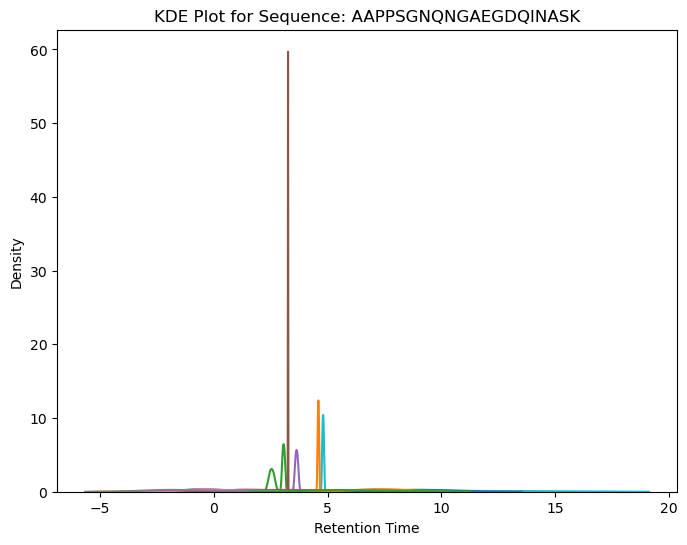

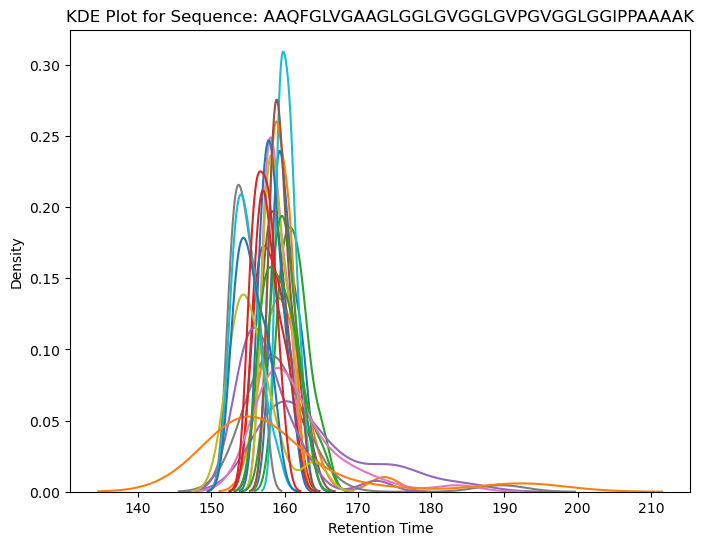

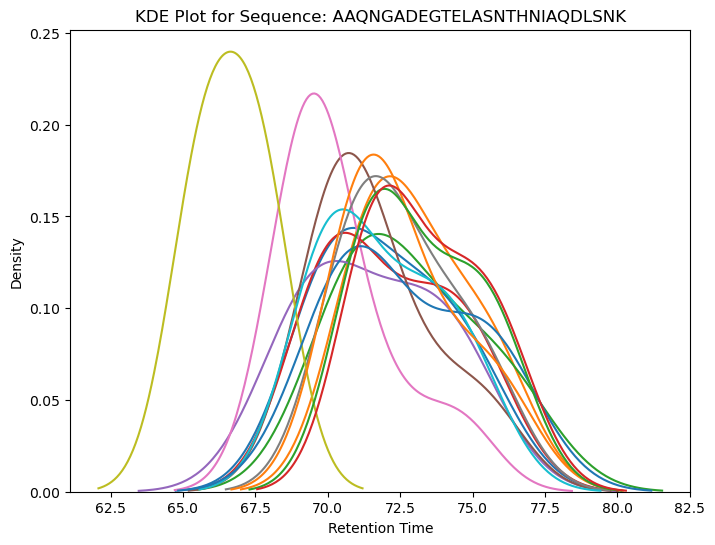

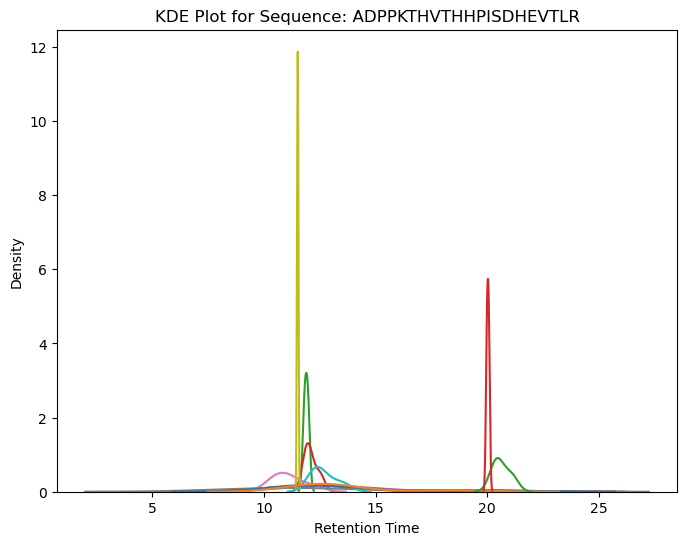

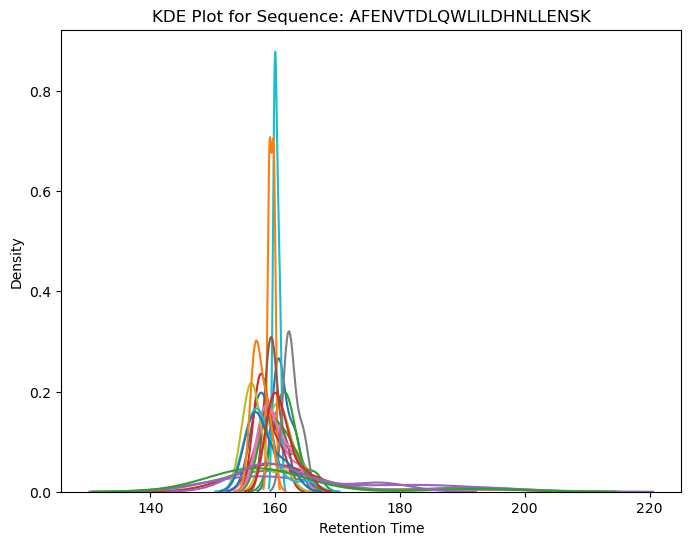

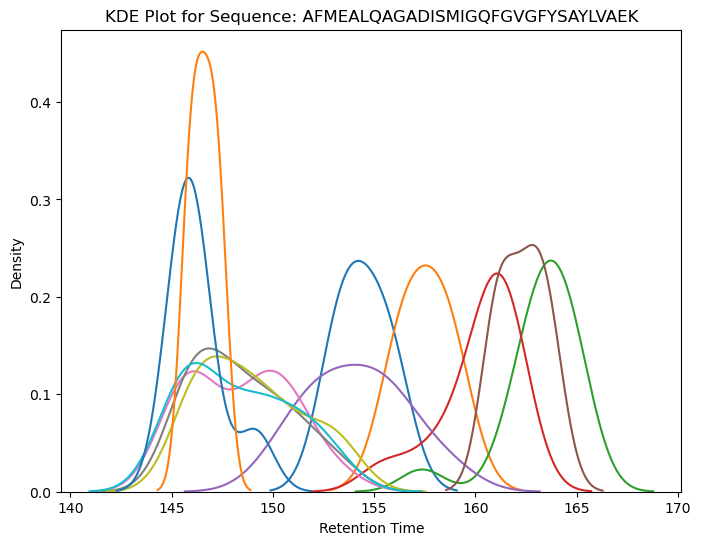

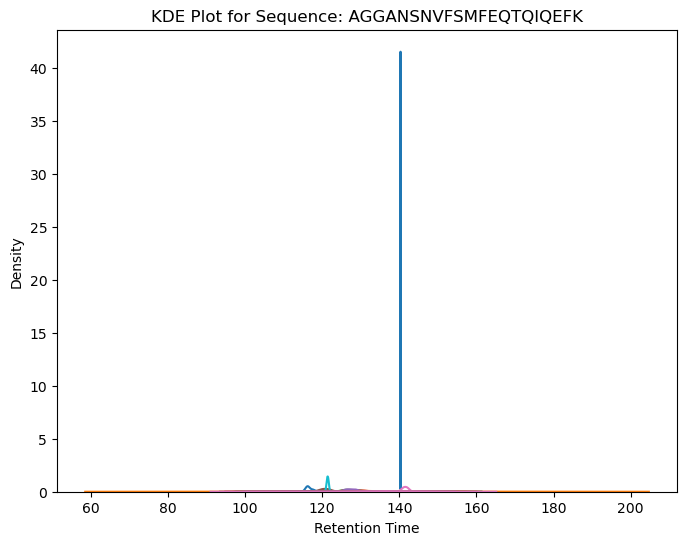

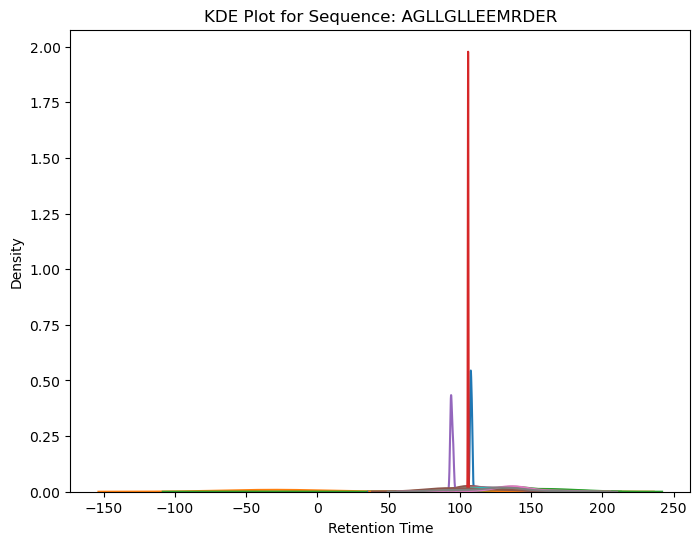

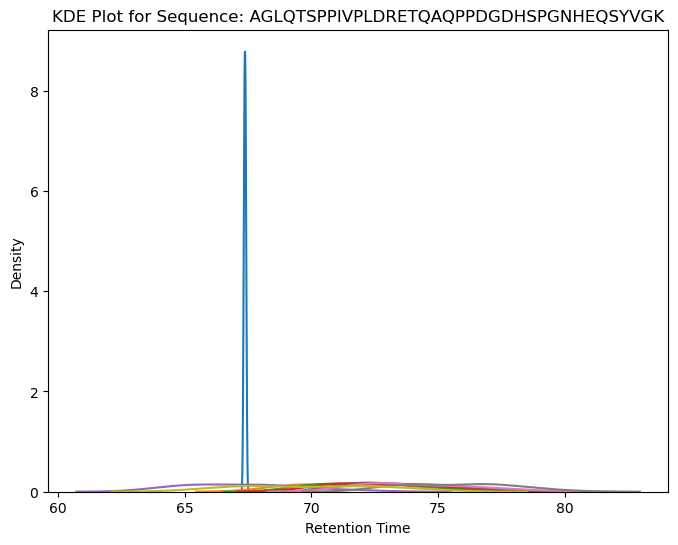

In [30]:
plot_kde_grouped(df_sequence,2,legend=False)